In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt


In [16]:
skin_type = 'DaG'

path_img = '/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok/' + skin_type + '/'
raw_image_train = np.load('/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok/dermatology_images/train_derm_img_413.npy') 
# import pdb;pdb.set_trace()
raw_image_test = np.load('/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok/dermatology_images/test_derm_img_395.npy') 

# raw_image_train = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/train_clinic_f_413.npy') /255
# raw_image_test = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/test_clinic_f_395.npy') /255


In [21]:
raw_image_train[0] .shape

(128, 128, 3)

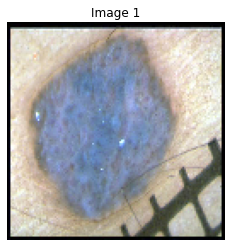

In [23]:
image = raw_image_train [0] /255

plt.imshow(image)
plt.title('Image 1')
plt.axis('off')  # 不顯示座標軸
plt.show()

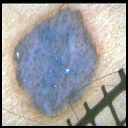

In [30]:
Image.fromarray((raw_image_train [0] ).astype(np.uint8))

In [20]:
raw_image_train 

array([[[[  1.,   1.,   1.],
         [  0.,   2.,   1.],
         [  0.,   1.,   6.],
         ...,
         [  0.,   0.,   2.],
         [  1.,   1.,   3.],
         [  0.,   0.,   0.]],

        [[  1.,   1.,   1.],
         [  2.,   0.,   1.],
         [  6.,   6.,   0.],
         ...,
         [  2.,   2.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  1.,   3.,   2.],
         [  5.,   3.,   4.],
         [  0.,   1.,   0.],
         ...,
         [ 16.,  18.,   7.],
         [  4.,   0.,   4.],
         [  1.,   0.,   6.]],

        ...,

        [[  1.,   1.,   1.],
         [ 14.,   8.,  22.],
         [188., 207., 177.],
         ...,
         [171., 187., 151.],
         [  0.,   1.,   3.],
         [  1.,   0.,   0.]],

        [[  1.,   0.,   5.],
         [  2.,   3.,   0.],
         [  0.,   9.,   5.],
         ...,
         [  2.,  12.,  13.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  1.,   0.,   5.],
       

In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, jaccard_score


from sklearn.model_selection import StratifiedKFold
from skimage import data_dir,io,color

def build_knn_graph(input_data, k):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(input_data)
    _, indices = knn.kneighbors(input_data)
    adjacency_matrix = torch.zeros(input_data.shape[0], input_data.shape[0])
    for i, neighbors in enumerate(indices):
        adjacency_matrix[i, neighbors] = 1
        
    return adjacency_matrix

def dataloader(datadir,skin_type, exp_mode):
    
    
    
    path_img = '/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok/' + skin_type + '/'
    raw_image_train = np.load(path_img  + 'train_derm_img_413.npy') 
    # import pdb;pdb.set_trace()
    raw_image_test = np.load(path_img  + 'test_derm_img_395.npy') 

    # raw_image_train = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/train_clinic_f_413.npy') /255
    # raw_image_test = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/test_clinic_f_395.npy') /255


    raw_f_train = np.load('/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok_old/meta_ok/'+ 'meta_train_413.npy')
    raw_f_test = np.load('/home/jding/Documents/PD_contrastive_research_0817/skin_dataset_ok_old/meta_ok/' +'meta_test_395.npy')
    # import pdb;pdb.set_trace()
    raw_f_train = preprocessing.scale(raw_f_train )
    raw_f_test = preprocessing.scale(raw_f_test )
    image_data_train = raw_image_train 
    feature_data_train = raw_f_train 

    image_data_train = torch.from_numpy(image_data_train ).float()
    image_data_train = torch.tensor(image_data_train ).transpose(1,3)
    feature_data_train = torch.from_numpy(feature_data_train).float()
    # import pdb;pdb.set_trace()
    image_data_flatten = torch.flatten(image_data_train, start_dim=1)
    image_data_flatten = image_data_flatten 

    # adj_train_img = kneighbors_graph(np.array(image_data_flatten), 200, mode='connectivity', include_self=True).toarray()

    adj_train_img = build_knn_graph(image_data_flatten,300).float()
    # import pdb;pdb.set_trace()
    # adj_train_img = torch.from_numpy(adj_train_img).float()


    image_data_test = torch.from_numpy(raw_image_test ).float()
    image_data_test = torch.tensor(image_data_test ).transpose(1,3)
    data_features_test = raw_f_test 
    test_feature_data = torch.from_numpy(data_features_test).float()

    # 创建测试用的邻接矩阵（这里假设所有病人之间都有连接）
    # test_adjacency_matrix = torch.ones((100, 100))


    ## testing image adj

    image_data_test_flatten = torch.flatten(image_data_test, start_dim=1)
    # image_data_test_flatten = image_data_test
    # adj_test_img = kneighbors_graph(np.array(image_data_test_flatten), 200, mode='connectivity', include_self=True).toarray()

    adj_test_img = build_knn_graph(image_data_test_flatten, 200).float()


    adj_f_knn_train =  build_knn_graph(raw_f_train, 300).float()
    # adj_f_knn_train = adj_f_knn_train.toarray()
    # adj_f_knn_train = torch.from_numpy(adj_f_knn_train).float()
    # adj_f_knn_test = kneighbors_graph(np.array(raw_f_test), 300, mode='connectivity', include_self=True)
    adj_f_knn_test = build_knn_graph(raw_f_test, 300).float()
    
    return image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
from keras.applications.mobilenet import MobileNet, preprocess_input
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 1024)
        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x
    
class GraphConvolution_img(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution_img, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        # self.linear2 = nn.Linear( 65536, 12)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, adjacency):
        # x = x.T @ self.linear(x)
       
        x = self.linear2(x)
        # import pdb;pdb.set_trace()
        x = torch.matmul(adjacency, x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.sigmoid(x)

        return x
    
class GraphConvolution_f(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution_f, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        # self.linear2 = nn.Linear( 65536, 12)
        self.linear2 = nn.Linear(256, 8)
        self.linear3 = nn.Linear(8, 3)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, adjacency):
        # x = x.T @ self.linear(x)
        
        # x = self.linear2(x)
        # import pdb;pdb.set_trace()
        x = torch.matmul(adjacency, x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        # import pdb;pdb.set_trace()
        return x
    
class AttentionNetwork_img(nn.Module):
    def __init__(self, num_features):
        super(AttentionNetwork_img, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = F.dropout(x, p=0.5)
        x = self.sigmoid(x)
        # x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        attention_weights = self.sigmoid(x)
        return attention_weights
    
class AttentionNetwork_f(nn.Module):
    def __init__(self, num_features):
        super(AttentionNetwork_f, self).__init__()
        self.fc1 = nn.Linear(num_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = F.dropout(x, p=0.5)
        x = self.sigmoid(x)
        # x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        attention_weights = self.sigmoid(x)
        return attention_weights


class Projection(nn.Module):

    def __init__(self, input_dim, hid_dim):
        super(Projection, self).__init__()
        self.fc1 = Linear(input_dim, hid_dim)
        self.fc2 = Linear(hid_dim, hid_dim)
        self.act_fn = nn.ReLU()
        self.layernorm = nn.LayerNorm(hid_dim, eps=1e-6)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.layernorm(x)
        x = self.fc2(x)
        return x
    
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features)
        self.a = nn.Linear(2 * out_features, 1)

    def forward(self, X, adj):
        h = self.W(X)
        N = h.size(0)
        
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * h.size(1))
        e = F.relu(self.a(a_input).squeeze(2))
        
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = torch.softmax(attention, dim=1)
        
        h_prime = torch.matmul(attention, h)
        return h_prime

# 定義 Graph Attention Network
class GAT_img(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GAT_img, self).__init__()
        self.attention1 = GraphAttentionLayer(in_features, hidden_features)
        self.attention2 = GraphAttentionLayer(hidden_features, num_classes)

    def forward(self, X, adj):
        h = self.attention1(X, adj)
        h = F.relu(h)
        logits = self.attention2(h, adj)
        return logits
    
class GAT_f(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GAT_f, self).__init__()
        self.attention1 = GraphAttentionLayer(in_features, hidden_features)
        self.attention2 = GraphAttentionLayer(hidden_features, num_classes)

    def forward(self, X, adj):
        # h =  torch.matmul(adj, X)
        
        h = self.attention1(X, adj)
        h = F.relu(h)
        logits = self.attention2(h, adj)
        return logits
    
class Model_SKIN(nn.Module):
    def __init__(self, projection, input_resnet, n_classes):
        super(Model_SKIN, self).__init__()
        #self.encoder = CNNEncoder()
        self.cnn_encoder = CNN()
        self.input_resnet = input_resnet
        self.n_classes = n_classes
        self.kmeans = KMeans(n_clusters=3) 
        # self.cnn_encoder = DeepEncoder() #torch.Size([300, 3, 64, 64])
        # self.cnn_encoder = CNNEncoder()
        # self.vgg_encoder = nn.Sequential(*list(vgg16.features.children()))
        self.gcn_img = GraphConvolution_img(64, 3)
        self.gcn_f = GraphConvolution_f(12, 3)
        self.gat_img = GAT_img(1024,256,3)
        self.gat_f = GAT_f(8,5,3)
        self.projection = projection
   
        # self.linear_vgg1 = nn.Linear(65536, 1024)
        # self.linear_vgg2 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(259, 2)
        self.linear2 = nn.Linear(256, 2)
        self.linear3 = nn.Linear(1030, 256)
        self.linear4 = nn.Linear(256,self.n_classes)
        self.linear_f = nn.Linear(14,self.n_classes)
        self.attention_f = AttentionNetwork_f(11)
        self.attention_img = AttentionNetwork_img(1027)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, x_f,adjacency_img, adjacency_f):
        # import pdb;pdb.set_trace()
        # x = self.encoder(x) #torch.Size([300, 65536])
        
        x_encoder = self.input_resnet(x)
        # import pdb;pdb.set_trace()
        #x_encoder = self.cnn_encoder(x)
        
        x_gat_img = self.gat_img(x_encoder, adjacency_img)
        # x_encoder = self.vgg_encoder(x)
        # x_encoder = torch.flatten(x_encoder, start_dim=1)
        # x_encoder = self.linear_vgg1(x_encoder)
        # x_encoder = self.linear_vgg2(x_encoder)
        # import pdb;pdb.set_trace()
        # import pdb;pdb.set_trace()
        
        x_gat_f = self.gat_f(x_f, adjacency_img)
        # import pdb;pdb.set_trace()
        x_gcn_f = self.gcn_f(x_f, adjacency_f)
        # import pdb;pdb.set_trace()
        # kmeans_output_f = self.kmeans.fit_transform(x_gcn_f.detach().numpy())
        # kmeans_tensor_f = torch.from_numpy(kmeans_output_f).float().to(x_gcn_f.device)
        
        x_gcn_img = self.gcn_img(x_encoder, adjacency_img)
        # kmeans_output_img = self.kmeans.fit_transform(x_gcn_img.detach().numpy())
        # kmeans_tensor_img = torch.from_numpy(kmeans_output_img).float().to(x_gcn_img.device)

        x_f_fusion = torch.cat((x_f, x_gat_f), 1)
        x_img = torch.cat((x_encoder, x_gat_img), 1)
       
        
        w_att_f = self.attention_f(x_f_fusion)
        w_att_img = self.attention_img(x_img)
        
        attended_gat_f = x_gat_f * w_att_f
        attended_gat_img = x_gat_img * w_att_img
        x_f_att = torch.cat((x_f_fusion, attended_gat_f), 1) # torch.Size([300, 17])
        x_img_att = torch.cat((x_img, attended_gat_img), 1) # torch.Size([300, 1029])
        
 
        emb1  = self.linear_f(x_f_att)
        # emb1  = self.linear4(emb1)
        
        emb2  = self.linear3(x_img_att)
        emb2  = self.linear4(emb2)
        #import pdb;pdb.set_trace()
        # x1 = self.linear1(x_f)
      

        # # x2 = self.linear2(x_encoder)
        # x2 = self.linear1(x_img)

        # x1 = self.softmax(x1)
        # x2 = self.softmax(x2)

        # x1 = self.linear1(attended_gcn)
        z = emb1 + emb2
        
        #import pdb;pdb.set_trace()
       
        #emb2 =  torch.from_numpy(emb2).to(torch.float32).to(device)
        #import pdb;pdb.set_trace()

    
        #z = torch.from_numpy(z).to(device)
        #emb2 = torch.from_numpy(emb2).float().to(device)
        
    

        #x1 = self.softmax(emb1) 
        #x2 = self.softmax(emb2) 
        
        #import pdb;pdb.set_trace()
    
        z  = self.softmax(z).to(torch.float32)
        
        #import pdb;pdb.set_trace()
        

        return emb1, emb2, z
    
    def nonlinear_transformation(self, h):
        z = self.projection(h)
        return z


In [4]:
# import json


# def train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, n_epochs, n_classes, exp_mode, beta):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
#     torch.cuda.is_available()
    
# #     class_name = 'Dag'
#     if model_select == 'resnet_18':
#         model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
#         # resnet = models.resnet18(pretrained=True)
#     elif model_select == 'resnet_34':
#          model_net = models.resnet34(pretrained=True)
#     elif model_select == 'resnet_50':
#         model_net = models.resnet50(pretrained=True)
#     elif model_select == 'densenet':
#          model_net = models.densenet121(pretrained=True)
        
#     #resnet = models.alexnet(pretrained=True)
    
#     model_net = model_net.to(device)
#     # 将最后一层的输出维度修改为类别数目
#     num_classes = 1024
    
#     num_features = model_net.fc.in_features #512 # Resnet
#     # num_features = model_net.classifier.in_features # Desnet101
#     # import pdb;pdb.set_trace()
#     model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
#     model_net.fc = model_net.fc.to(device) #512 # Resnet
#     # model_net.classifier = nn.Linear(num_features, num_classes) #desnet

#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type, exp_mode)
 
# #     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
#     projection = Projection(262, 3)
#     if datadir == 'skin':
#         model = Model_SKIN(projection, model_net, n_classes).to(device)
#     elif datadir == 'abide':
#         model = Model_ABIDE(projection, model_net, n_classes).to(device)
#     elif datadir == 'pd':
#         model = Model_PD(projection, model_net, n_classes).to(device)

#     class_weights = torch.full((1,n_classes),0.5).view(-1)
#     criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

#     if loss_select == 'Contrastive_loss':
#          criterion2 = contrastive_loss

#     elif loss_select == 'MGEC_loss':
#         criterion2 = MGECLoss()
        
#     elif loss_select == 'InfoNCE_loss':
#         criterion2 = info_loss
        
#     elif loss_select == 'SAC_loss':
#         criterion2 = SACLoss()

#     # criterion3 = loss_dependence
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     class_name = category

#     training_range = tqdm(range(n_epochs))

#         # y_train = y_train.to(device)
#         # y_test = y_test.to(device)
        
#         # import pdb;pdb.set_trace()


#     projection = Projection(262, 3)
#     if datadir == 'skin':
#         model = Model_SKIN(projection, model_net, n_classes).to(device)
#     elif datadir == 'abide':
#         model = Model_ABIDE(projection, model_net, n_classes).to(device)
#     elif datadir == 'pd':
#         model = Model_PD_Weight(projection, model_net, n_classes).to(device, dtype=torch.float32)

#     class_weights = torch.full((1,n_classes),0.5).view(-1)
#     criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

#     if loss_select == 'Contrastive_loss':
# #              criterion2 = contrastive_loss
#         criterion2 = contrastive_loss

#     elif loss_select == 'MGEC_loss':
#         criterion2 = MGECLoss()

#     elif loss_select == 'InfoNCE_loss':
#         criterion2 = info_loss

#     elif loss_select == 'SAC_loss':
#         criterion2 = SACLoss()

# # criterion3 = loss_dependence
#     optimizer = optim.Adam(model.parameters(), lr=0.001)



#     training_range = tqdm(range(n_epochs))

#     for epoch in training_range:
#         optimizer.zero_grad()
#         # cnn_z  =  cnn_encoder(image_data)
#         # 前向传播

#         image_data_train = image_data_train.to(device)
#         feature_data_train = feature_data_train.to(device)
#         adj_train_img = adj_train_img.to(device)
#         adj_f_knn_train = adj_f_knn_train.to(device)

#         output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)

#         y = torch.tensor(label_return(dataset_choice, class_name, "train", exp_mode)).to(device)
#         # import pdb;pdb.set_trace()
#         loss_ce1 = criterion1(output1, y)
#         loss_ce2 = criterion1(output2, y)
#         alpha = beta

#         if loss_select == 'Contrastive_loss':
#             adj = adj_train_img +  adj_f_knn_train
#             diag = torch.diag(adj.sum(dim=1))
#             loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
#             loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra
#             # loss = loss_ce1 + loss_ce2
#         elif loss_select == 'MGEC_loss':
#             adj = adj_train_img +  adj_f_knn_train
#             diag = torch.diag(adj.sum(dim=1))
#             loss_extra = criterion2(output1, output2, adj, diag )
#             loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
#             #loss = loss_extra

#         elif loss_select == 'InfoNCE_loss':
#             loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
#             loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

#         elif loss_select == 'SAC_loss':    
#             adj = adj_train_img +  adj_f_knn_train
#             diag = torch.diag(adj.sum(dim=1))
#             loss_extra = criterion2(emb, adj)
#             loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
#         elif loss_select == 'only_CE':
#             # loss = loss_ce1 + loss_ce2
#             loss = loss_ce1


#         loss.backward()
#         optimizer.step()
#         # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
#         # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

#     model.eval()
#     with torch.no_grad():
#         # import pdb;pdb.set_trace()
#         image_data_test = image_data_test.to(device)
#         test_feature_data = test_feature_data.to(device)
#         adj_test_img = adj_test_img.to(device)
#         adj_f_knn_test = adj_f_knn_test.to(device)

#         test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

#         # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
#         m = nn.Softmax(dim=1)
#         # import pdb;pdb.set_trace()
#         test_output = test_output1 + test_output2
#     #     test_output = emb

#         #z = test_output1 + test_output2

#         #num_clusters = 3
#         #kmeans = KMeans(n_clusters=num_clusters)

#         #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
#         #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)
#         false_positives = []
#         false_negatives = []


#         pred =  m(test_output).argmax(dim=1)
#         #pred = cluster_labels
#         # test_output = test_output.argmax(dim=1)


#         # y_test = torch.empty(100).random_(2)
#     #     y_test = torch.tensor(label_3_test).to(device)
#         y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test", exp_mode)).to(device)

#         # import pdb;pdb.set_trace()
#         correct = (pred  == y_test).sum().item()
#         accuracy = correct / len(y_test)
# #             import pdb;pdb.set_trace()
# #             fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
# #             roc_auc = auc(fpr, tpr)
# #             all_fpr.append(fpr)
# #             all_tpr.append(tpr)
# #             all_roc_auc.append(roc_auc)
# #             all_aucs.append(roc_auc)
# #             import pdb;pdb.set_trace()

#         false_positive_indices = np.where((y_test.cpu().numpy() == 0) & (pred.cpu().detach().numpy() == 1))[0]
#         false_negative_indices = np.where((y_test.cpu().numpy()  == 1) & (pred.cpu().detach().numpy() == 0))[0]

#         false_positives.append(false_positive_indices.tolist())
#         false_negatives.append(false_negative_indices.tolist())

#         cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
#         plt.figure()
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#         plt.title(f'Confusion Matrix - Fold')
#         plt.xlabel('Predicted Labels')
#         plt.ylabel('True Labels')

#         plt.figure()

# #             plt.figure(figsize=(8, 6))

#         # 分別取出不同類別的資料
# #             normal_data = test_output[pred == 0].cpu().detach().numpy()
# #             neurodegenerative_data = test_output[pred == 1].cpu().detach().numpy()



# #             normal_data = test_feature_data[pred == 0].cpu().detach().numpy()
# #             neurodegenerative_data = test_feature_data[pred == 1].cpu().detach().numpy()
#         label_1_data = test_feature_data[y_test == 0].cpu().detach().numpy()
#         label_2_data = test_feature_data[y_test == 1].cpu().detach().numpy()
#         label_3_data = test_feature_data[y_test == 2].cpu().detach().numpy()

#         # Labels and titles setup
# #             x_labels = ["S-R", "AP-R", "PP-R", "C-R", "P/C-R", "PA"]
# #             y_labels = ["S-L", "AP-L", "PP-L", "C-L", "P/C-L", "CA"]

#         x_labels = ['diagnosis_numeric', 'pigment_network_numeric', 'blue_whitish_veil_numeric', 'vascular_structures_numeric']
#         y_labels = ['pigmentation_numeric', 'streaks_numeric', 'dots_and_globules_numeric', 'regression_structures_numeric']

#         titles = ["variables pair 1", "variables pair 2", "variables pair 3",
#                   "variables pair 4"]

#         # Visualization
#         n_rows = 2
#         n_cols = 2

#         # Ensure there are enough columns in the data for plotting
#         if test_feature_data.shape[1] >= 2:
#             fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
#             axes = axes.flatten()
#             plt.tight_layout(pad=4.0)

#             for i in range(len(x_labels)):
#                 ax = axes[i]
#                 # Plot each category
#                 ax.scatter(label_1_data[:, i], label_1_data[:, i + 1], c='green', marker='o', edgecolors='black', label='Normal')
#                 ax.scatter(label_2_data[:, i], label_2_data[:, i + 1], c='red', marker='^', edgecolors='black', label='Abnormal')
#                 if label_3_data.size > 0:
#                     ax.scatter(label_3_data[:, i], label_3_data[:, i + 1], c='#FFA07A', marker='s', edgecolors='black', label='Mid-Abnormal')
# #                         ax.scatter(other_data[:, i], other_data[:, i + 1], c='blue', marker='s', edgecolors='black', label='Other')

#                 ax.set_xlabel(x_labels[i % len(x_labels)], fontsize=18)
#                 ax.set_ylabel(y_labels[i % len(y_labels)], fontsize=18)
#                 ax.set_title(titles[i % len(titles)], fontsize=20)
#                 ax.legend(fontsize=10)
#             plt.subplots_adjust(hspace=0.4, wspace=0.4)
# #                 plt.savefig("plot_output.png", format='png', dpi=300)  # Increased DPI for better resolution
#             plt.savefig("plot_output_skin.pdf", format='pdf')
# #                 plt.close(fig)  # Close the figure to free up memory


# #                 plt.show()


#         else:
#             print("Insufficient columns in data to plot scatter plots.")




    
            
# def main():
# #     parser = argparse.ArgumentParser()
# #     parser.add_argument('--img_data_dir', type=str, default='pd')
# #     parser.add_argument('--skin_type', type=str, default='dermatology_images')
# #     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
# #     parser.add_argument('--model_select', type=str, default='densenet')
# #     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
# #     parser.add_argument('--dataset_choice', type=str, default='pd')
# #     parser.add_argument('--category', type=str)
# #     parser.add_argument('--n_epoch', type=int, default=300)
# #     parser.add_argument('--n_classes', type=int, default=2)
    
# #     args = parser.parse_args()

#     flag = torch.cuda.is_available()
#     if flag:
#         print("CUDA可使用")
#     else:
#         print("CUDA不可用")

#     ngpu= 1
# #     os.environ['CUDA_VISIBLE_DEVICES'] ='0'
#     # Decide which device we want to run on
#     device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#     torch.cuda.set_device(0)
#     print("驱动为：",device)
#     print("GPU型号: ",torch.cuda.get_device_name(0))


#     datadir = 'skin'
#     skin_type = 'dermatology_images'
#     losses_choice = 'Contrastive_loss'
#     model_select = 'resnet_18'
#     dataset_choice = 'skin'
#     category = 'DaG'  # 设置正确的类别值
#     exp_mode='normal_abnormal'
#     beta=0.4
#     n_epochs = 300
#     n_classes = 3

#     train_eval(datadir, skin_type, losses_choice, model_select, dataset_choice, category, n_epochs, n_classes, exp_mode, beta)
# #     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


# if __name__ == '__main__':
#     main()


CUDA可使用
驱动为： cuda:0
GPU型号:  NVIDIA GeForce RTX 3070


/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 2/300 [00:00<01:57,  2.54it/s]


KeyboardInterrupt: 

In [ ]:
import json
from sklearn.manifold import TSNE
import matplotlib.offsetbox as offsetbox
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, n_epochs, n_classes, exp_mode, beta):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
#     class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    num_features = model_net.fc.in_features #512 # Resnet
    # num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    model_net.fc = model_net.fc.to(device) #512 # Resnet
    # model_net.classifier = nn.Linear(num_features, num_classes) #desnet

    image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type, exp_mode)
 
#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
    projection = Projection(262, 3)
    if datadir == 'skin':
        model = Model_SKIN(projection, model_net, n_classes).to(device)
    elif datadir == 'abide':
        model = Model_ABIDE(projection, model_net, n_classes).to(device)
    elif datadir == 'pd':
        model = Model_PD(projection, model_net, n_classes).to(device)

    class_weights = torch.full((1,n_classes),0.5).view(-1)
    criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

    if loss_select == 'Contrastive_loss':
         criterion2 = contrastive_loss

    elif loss_select == 'MGEC_loss':
        criterion2 = MGECLoss()
        
    elif loss_select == 'InfoNCE_loss':
        criterion2 = info_loss
        
    elif loss_select == 'SAC_loss':
        criterion2 = SACLoss()

    # criterion3 = loss_dependence
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    class_name = category

    training_range = tqdm(range(n_epochs))

        # y_train = y_train.to(device)
        # y_test = y_test.to(device)
        
        # import pdb;pdb.set_trace()


    projection = Projection(262, 3)
    if datadir == 'skin':
        model = Model_SKIN(projection, model_net, n_classes).to(device)
    elif datadir == 'abide':
        model = Model_ABIDE(projection, model_net, n_classes).to(device)
    elif datadir == 'pd':
        model = Model_PD_Weight(projection, model_net, n_classes).to(device, dtype=torch.float32)

    class_weights = torch.full((1,n_classes),0.5).view(-1)
    criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

    if loss_select == 'Contrastive_loss':
#              criterion2 = contrastive_loss
        criterion2 = contrastive_loss

    elif loss_select == 'MGEC_loss':
        criterion2 = MGECLoss()

    elif loss_select == 'InfoNCE_loss':
        criterion2 = info_loss

    elif loss_select == 'SAC_loss':
        criterion2 = SACLoss()

# criterion3 = loss_dependence
    optimizer = optim.Adam(model.parameters(), lr=0.001)



    training_range = tqdm(range(n_epochs))

    for epoch in training_range:
        optimizer.zero_grad()
        # cnn_z  =  cnn_encoder(image_data)
        # 前向传播

        image_data_train = image_data_train.to(device)
        feature_data_train = feature_data_train.to(device)
        adj_train_img = adj_train_img.to(device)
        adj_f_knn_train = adj_f_knn_train.to(device)

        output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
#         import pdb;pdb.set_trace()
        y = torch.tensor(label_return(dataset_choice, class_name, "train", exp_mode)).to(device)
        # import pdb;pdb.set_trace()
        loss_ce1 = criterion1(output1, y)
        loss_ce2 = criterion1(output2, y)
        alpha = beta

        if loss_select == 'Contrastive_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
            loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra
            # loss = loss_ce1 + loss_ce2
        elif loss_select == 'MGEC_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(output1, output2, adj, diag )
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            #loss = loss_extra

        elif loss_select == 'InfoNCE_loss':
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

        elif loss_select == 'SAC_loss':    
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(emb, adj)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
        elif loss_select == 'only_CE':
            # loss = loss_ce1 + loss_ce2
            loss = loss_ce1


        loss.backward()
        optimizer.step()
        # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

    model.eval()
    with torch.no_grad():
        image_data_test = image_data_test.to(device)
        test_feature_data = test_feature_data.to(device)
        adj_test_img = adj_test_img.to(device)
        adj_f_knn_test = adj_f_knn_test.to(device)

        test_output1, test_output2, emb = model(image_data_test, test_feature_data, adj_test_img, adj_f_knn_test)
        m = nn.Softmax(dim=1)
        test_output = test_output1 + test_output2
        pred = m(test_output).argmax(dim=1)

        y_test = torch.from_numpy(label_return(dataset_choice, class_name, "test", exp_mode)).to(device)

    # Convert embeddings and labels to numpy arrays for t-SNE

    emb_np = emb.cpu().numpy()
    pred_np = pred.cpu().numpy()
    image_data_np = image_data_test.cpu().numpy().transpose(0, 2, 3, 1)  # Assuming image_data_test is in (N, C, H, W) format

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(emb_np)

    # Plotting the t-SNE result
    plt.figure(figsize=(20, 16))
    ax = plt.subplot(111)
    colors = ['r', 'g', 'b']

    for i in range(3):  # Assuming there are 3 classes
        indices = pred_np == i
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], c=colors[i], label=f'Class {i}', alpha=0.6)

    # Randomly select 5 indices
    random_indices = random.sample(range(len(image_data_np)), 5)

    # Function to plot images on t-SNE points
    def imscatter(x, y, images, ax=None, zoom=1):
        if ax is None:
            ax = plt.gca()
        for i in range(len(images)):
            img = Image.fromarray((images[i]).astype(np.uint8))  # Convert to PIL Image
            img.thumbnail((80, 80), Image.ANTIALIAS)  # Resize image
            imagebox = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
            ax.add_artist(ab)

    # Plot images on the t-SNE points
    imscatter(tsne_result[random_indices, 0], tsne_result[random_indices, 1], image_data_np[random_indices], ax=ax, zoom=1)

    plt.title('t-SNE plot of predicted classes with selected images')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.legend()
    plt.show()




        

    
    
            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    ngpu= 1
#     os.environ['CUDA_VISIBLE_DEVICES'] ='0'
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    torch.cuda.set_device(0)
    print("驱动为：",device)
    print("GPU型号: ",torch.cuda.get_device_name(0))


    datadir = 'skin'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'resnet_18'
    dataset_choice = 'skin'
    category = 'PN'  # 设置正确的类别值
    exp_mode='normal_abnormal'
    beta=0.4
    n_epochs = 300
    n_classes = 3

    train_eval(datadir, skin_type, losses_choice, model_select, dataset_choice, category, n_epochs, n_classes, exp_mode, beta)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


CUDA可使用
驱动为： cuda:0
GPU型号:  NVIDIA GeForce RTX 3070


/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/300 [00:00<?, ?it/s]

 48%|████▊     | 144/300 [00:27<00:30,  5.12it/s]


 57%|█████▋    | 170/300 [00:33<00:25,  5.12it/s]

# Plot similarity matrix